# UNet

This modifies the origina UNet architecture by adding a batch normalization layer after each convolution

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

# Data 

check if pytorch is using gpu

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [3]:
path = Path('../data/carvana/')
path.ls()

[PosixPath('../data/carvana/sample_submission.csv'),
 PosixPath('../data/carvana/train_hq.zip'),
 PosixPath('../data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('../data/carvana/train_masks.csv'),
 PosixPath('../data/carvana/metadata.csv'),
 PosixPath('../data/carvana/train'),
 PosixPath('../data/carvana/test.zip'),
 PosixPath('../data/carvana/.ipynb_checkpoints'),
 PosixPath('../data/carvana/test_hq.zip'),
 PosixPath('../data/carvana/train_masks')]

In [4]:
fnames = get_image_files(path/'train')
fnames[:3]

[PosixPath('../data/carvana/train/d0392fd5feb6_01.jpg'),
 PosixPath('../data/carvana/train/dd70a0a51e3b_03.jpg'),
 PosixPath('../data/carvana/train/781c5338fe02_06.jpg')]

In [5]:
labels = get_image_files(path/'train_masks')
labels[:3]

[PosixPath('../data/carvana/train_masks/e114fcbb9723_10_mask.gif'),
 PosixPath('../data/carvana/train_masks/6c3470c34408_10_mask.gif'),
 PosixPath('../data/carvana/train_masks/f707d6fbc0cd_13_mask.gif')]

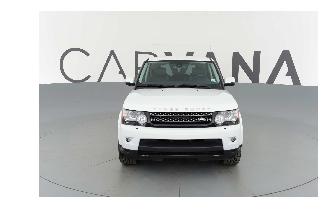

In [6]:
fname = fnames[0]
img = open_image(fname)
img.show(figsize=(5,5))

function to return the path to the mask for any training image

In [7]:
def get_mask(fname): return Path(str(fname.parent) + '_masks') / (fname.name[:-4] + '_mask.gif')

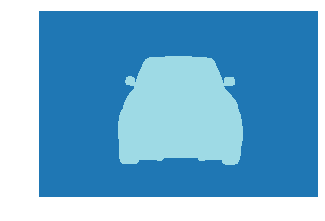

In [8]:
mask = open_mask(get_mask(fname))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([1280, 1918]), tensor([[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]))

## Create a Dataset

In [10]:
codes = array(['background', 'car'])

In [11]:
bs, size = 4, 512
bs, size

(4, 512)

**change SegmentationItemList class to work on binary segmentation**

In [12]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageItemList):
    _label_cls = SegLabelListCustom

In [13]:
src = (SegItemListCustom.from_folder(path/'train')
       .random_split_by_pct()
       .label_from_func(get_mask, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

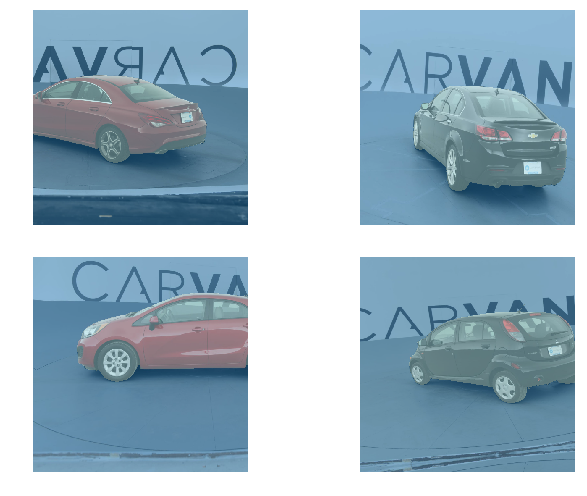

In [15]:
data.show_batch(2, figsize=(10,7))

## Model Architecture

In [18]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

In [19]:
def upsample_block(in_channels, out_channels):
    return nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)

In [20]:
def center_crop(features, target_size_h, target_size_w):
    """
        When combining the upsampled output with the output of the encoder, the features 
        from the encoder have a larger height and width than the upsampled output
       
        The features from the contracting path are cropped to have the same size
        as the upsampled output.
    """
    _, _, encoder_size_h, encoder_size_w = features.shape
    crop_size_h = (encoder_size_h - target_size_h) // 2
    crop_size_w = (encoder_size_w - target_size_w) // 2
    
    return features[:, :, crop_size_h:(crop_size_h + target_size_h), 
                   crop_size_w:(crop_size_w + target_size_w)]

In [21]:
class DecoderBlock(nn.Module):
    """
        Implements one step of the expansive path
        
        Every step in the expansive path consists of:
        1.An upsampling of the feature map followed by a 2x2 convolution 
          that halves the number of feature channels.
        2.A concatenation with the correspondingly cropped feature map from the
          contracting path, and two 3x3 convolutions, each followed by a relu.
        
    """
    def __init__(self, n_channels):
        super().__init__()
        
        self.up_conv = upsample_block(n_channels, n_channels//2)    
        self.normal_conv = unet_block(n_channels, n_channels//2)
    
    def forward(self, x, hook):
        out = self.up_conv(x)
        out = torch.cat((center_crop(hook, out.shape[2], out.shape[3]),
                            out), 1)
        out = self.normal_conv(out)
        return out

In [22]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        ### contracting path
        self.c_one = unet_block(in_channels, 64)  # first step in contracting path
        self.c_two = unet_block(64, 128)
        self.c_three = unet_block(128, 256)
        self.c_four = unet_block(256, 512)
        self.c_five = unet_block(512, 1024)
        
        self.max_pool = nn.MaxPool2d(2, stride=2)
        
        ### expansive path
        self.e_one = DecoderBlock(1024)
        self.e_two = DecoderBlock(512)
        self.e_three = DecoderBlock(256)
        self.e_four = DecoderBlock(128)
        
        self.final_layer = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        hook_one = self.c_one(x)
        hook_two = self.c_two(self.max_pool(hook_one))
        hook_three = self.c_three(self.max_pool(hook_two))
        hook_four = self.c_four(self.max_pool(hook_three))
        
        encoder_output = self.c_five(self.max_pool(hook_four))
        
        e_one = self.e_one(encoder_output, hook_four)
        e_two = self.e_two(e_one, hook_three)
        e_three = self.e_three(e_two, hook_two)
        e_four = self.e_four(e_three, hook_one)
        
        out = self.final_layer(e_four)
        
        return out

In [23]:
model = UNet(in_channels=3, out_channels=2).cuda()

**test with random input**

In [28]:
rand_image = torch.randn(1, 3, 640, 959).cuda()

In [29]:
test = model(rand_image)
test.shape

torch.Size([1, 2, 640, 944])

# Train

In [24]:
def loss_funtion(logits, target):
    target = target.squeeze_(dim=1)
    
    return F.cross_entropy(logits, target)

In [25]:
learn = Learner(data, model, loss_func=loss_funtion, metrics=dice)

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


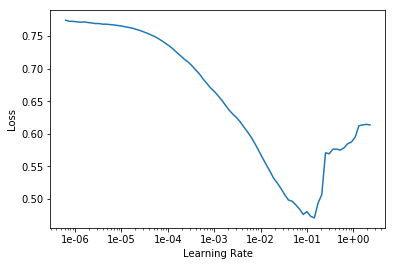

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,dice
1,0.055659,0.041495,0.970965
2,0.023651,0.019298,0.987721
3,0.014511,0.039271,0.984236
4,0.010420,0.032505,0.982798
5,0.009151,0.008801,0.994329


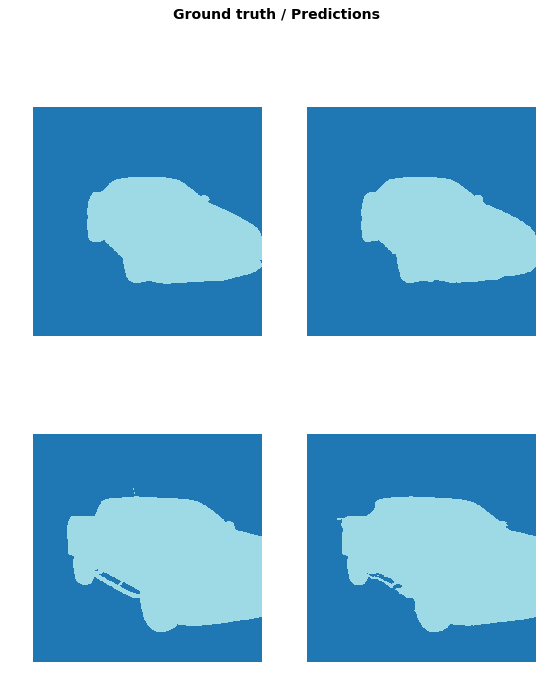

In [30]:
learn.show_results(rows=2, figsize=(9, 11), alpha=1)